In [1]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs
from matplotlib import pyplot
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings   
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from math import sqrt 
import math

In [2]:
data=pd.read_csv("data.csv") 
data_original=data.copy()

#### Convert date column into date format

In [3]:
data['calendar_date'] = pd.to_datetime(data.calendar_date,format='%m/%d/%Y') 
data.index = data['calendar_date']
data.sort_index(inplace=True)

### There are some negative volume, revenue
+ It could be due to goods return
+ It might be data error, some numbers are mistakely with negative sign

Assumption: I consider it as an error. Therefore, I would change the sign of negative numbers

Before that let's look at number of rows with negative values corresponding each column

In [4]:
data[data<0].count()

product_id          0
calendar_date    1340
volume_sold         1
revenue             1
cost                1
vdm1                1
vwm1                6
vmm1                6
vmm2                0
vmm13               0
rdm1                1
rwm1                6
rmm1                5
rmm2                0
rmm13               0
cdm1                1
cwm1                6
cmm1                6
cmm2                0
cmm13               0
mpdm1               0
mpwm1               0
mpmm1               0
mpmm2               0
mpmm13              0
stock_level         2
retail_price        0
woy                 0
dtype: int64

In [5]:
data['volume_sold']=data['volume_sold'].abs()
data['revenue']=data['revenue'].abs()
data['cost']=data['cost'].abs()
data['vdm1']=data['vdm1'].abs()
data['vwm1']=data['vwm1'].abs()
data['vmm1']=data['vmm1'].abs()
data['rdm1']=data['rdm1'].abs()
data['rwm1']=data['rwm1'].abs()
data['rmm1']=data['rmm1'].abs()
data['cdm1']=data['cdm1'].abs()
data['cwm1']=data['cwm1'].abs()
data['cmm1']=data['cmm1'].abs()
data['stock_level']=data['stock_level'].abs()

### Helper Functions

In [6]:
def randomized_search_CV(algorithm,tuned_parameters,train_x,train_y,iteration,verbose_int,jobs_int=1):
    """
    This function performs randomized search on set of features, perform cross validation and fit the data in the specified model.
    It returns best set of features.
    
    Args:
        algorithm: Model to fit
        tuned_parameters: Set of possible parameters to choose
        train_x: training data (features) 
        train_y: training label
        iteration: number of itearation to choose random set of parameters
        
    Returns:
        set of best parameters
    
    """
    
    score = 'neg_mean_squared_error'

    print("# Tuning hyper-parameters for mean_squared_error" )
    print()
     
    clf = RandomizedSearchCV(algorithm, param_distributions=tuned_parameters, cv=5,n_iter = iteration, scoring='neg_mean_squared_error',verbose=verbose_int,n_jobs=jobs_int)
    clf.fit(train_x,train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    #print("Grid scores on development set:")
    #print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
        
    return clf.best_params_

In [7]:
def nwmse_metric(df_test):
    """
    This function is used to compute "normalized weighted mean squared error" 
    
    Args:
        df_test: panda dataframe observed and predictions
        
    Returns:
        norm_weighted_mean_squared_error
    """
    
    sum_error = 0.0
    weight_sum=0
    for index,row in df_test.iterrows():
        prediction_error = row['predictions'] - row['volume_sold']
        weight=math.log(row['volume_sold']+1)+1
        sum_error += weight*(prediction_error ** 2)
        weight_sum+=weight
        
    norm_weighted_mean_squared_error = sum_error / (float(len(df_test))*weight_sum)
    
    #return math.sqrt(mean_error)
    return norm_weighted_mean_squared_error

In [8]:
def model_quality(df_test,model):
    print("__"*50,"\n")
    print('The RMSE of the '+str(model)+' Regression is',sqrt(mean_squared_error(df_test['volume_sold'],df_test['predictions'])))
    print("__"*50,"\n")
    
    print('The MSE of the '+str(model)+' Regression is',mean_squared_error(df_test['volume_sold'],df_test['predictions']))
   
    print("__"*50,"\n")
    print('The MAE of the '+str(model)+' Regression is',mean_absolute_error(df_test['volume_sold'],df_test['predictions']))

    print("__"*50,"\n")
    
    print("Normalized weighted mean sqaure error: "+str(nwmse_metric(df_test)))
    
    print("__"*50,"\n")
    print("Sum of Original Sales for next 28 days: ",df_test['volume_sold'].sum())
    print("Sum of Predicted Sales for next 28 days: ",df_test['predictions'].sum())
    print('The difference between model original and predictions values of the '+str(model)+' Regression is',df_test['volume_sold'].sum() - df_test['predictions'].sum())

    
    print("__"*50,"\n")

In [9]:
def pre_process_data(data,product,size_test_data,product_list):
    
    data=data.dropna()
    
    data_model_df=data[data['product_id']==product]
    
    for j in range(len(product_list)):
        if product_list[j]!=product:
            data_model_df[str(product_list[j])+'_comp1_price']=data[data['product_id']==product_list[j]]['retail_price']
            data_model_df['Item_comp_price_diff_'+str(product_list[j])]=data[data['product_id']==product]['retail_price'] - data_model_df[str(product_list[j])+'_comp1_price']
    features_col=list(set(data_model_df.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy","vdm1","vwm1","vmm1","rdm1","rwm1","rmm1","cdm1","cwm1","cmm1","mpdm1","mpwm1","mpmm1"]))
    
    
    df_train=data_model_df[data_model_df["calendar_date"]<="2017-10-31"][features_col] 
    df_test=data_model_df[data_model_df["calendar_date"]>"2017-10-31"][features_col]
   
    df_test=df_test.head(size_test_data)
    
    return df_train,df_test

In [10]:
def plot_series(df_train,df_test,Prediction):
        
        ts = df_train['volume_sold'] 
        ts1=ts.append(df_test['volume_sold'])
        ts2=ts.append(df_test['predictions'])
        
        plt.figure(figsize=(16,8)) 
        plt.plot(ts2,'r',label='Predictions') 
        plt.plot(ts1,'g',label='Original Series')
        plt.title('Time Series') 
        plt.xlabel("Time(year-month)") 
        plt.ylabel("Item sold count") 
        plt.legend(loc='best')
        plt.show()

In [11]:
# Based on assumption that we have mean_retail_price (retail_price on next 1 month)
def price_diff_retail_price_with_max_price_in_previous_periods(df):
    
    df['Retail_price_diff_max_price_in_last_2month']=df['retail_price'] -df['mpmm2']/28
    df['Retail_price_diff_max_price_in_last_year_13month']=df['retail_price'] -df['mpmm13']/28
    
    return df

In [12]:
def weekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 

In [13]:
def fit_features_scaler(df_train):
    
    scaler = StandardScaler()
    scaler.fit(df_train.drop('volume_sold', axis=1))
        
    return scaler
    
def transform_features(df, scaler):
   
    df_features = df.drop('volume_sold', axis=1)
    df_scaled = pd.DataFrame(scaler.transform(df_features), columns=df_features.columns)
       
    
    return df_scaled

# Features

#### Time Features

In [14]:
data['month']=data.calendar_date.dt.month 
data['day']=data.calendar_date.dt.day

In [15]:
temp2 = data['calendar_date'].apply(weekend) 
data['weekend']=temp2

#### Difference in current retail price with previous maximum prices

In [16]:
data=price_diff_retail_price_with_max_price_in_previous_periods(data)

#### Feature List

In [17]:
features_col=list(set(data.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy","vdm1","vwm1","vmm1","rdm1","rwm1","rmm1","cdm1","cwm1","cmm1","mpdm1","mpwm1","mpmm1"]))

# Modeling

### Linear Regression

In [18]:
tuned_parameters = {'fit_intercept':[True,False], 
                    'normalize':[True,False], 
                    'copy_X':[True, False]}


______________
Product: 13701
# Tuning hyper-parameters for mean_squared_error

Best parameters set found on development set:

{'normalize': False, 'fit_intercept': True, 'copy_X': True}



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


____________________________________________________________________________________________________ 

The RMSE of the Regression Regression is 625.0180030118668
____________________________________________________________________________________________________ 

The MSE of the Regression Regression is 390647.50408894196
____________________________________________________________________________________________________ 

The MAE of the Regression Regression is 441.66777455916036
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 15965.018185548213
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510
Sum of Predicted Sales for next 28 days:  4943.33995712407
The difference between model original and predictions values of the Regression Regression is 11566.66004287593
_________________________________

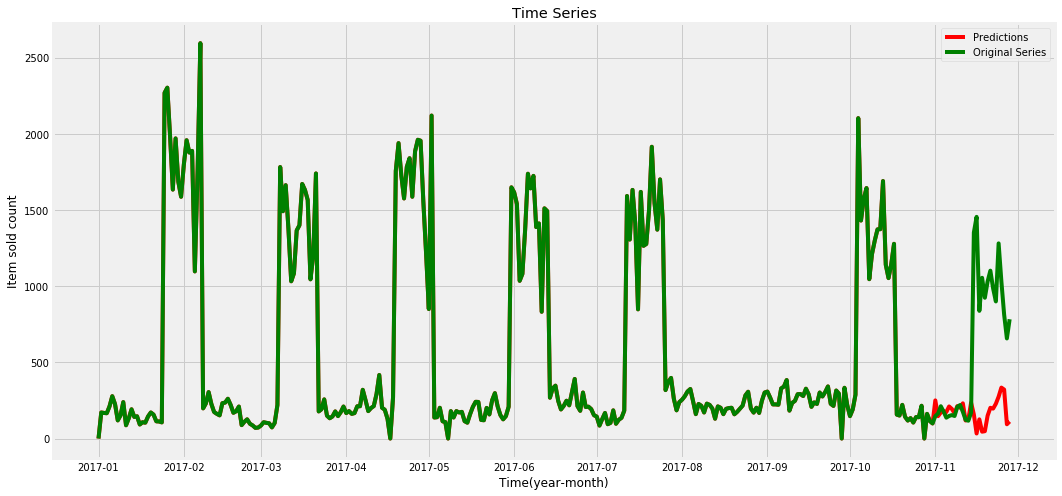

______________
Product: 26104
# Tuning hyper-parameters for mean_squared_error

Best parameters set found on development set:

{'normalize': True, 'fit_intercept': True, 'copy_X': True}

____________________________________________________________________________________________________ 

The RMSE of the Regression Regression is 3.7667373343306183
____________________________________________________________________________________________________ 

The MSE of the Regression Regression is 14.188310145840132
____________________________________________________________________________________________________ 

The MAE of the Regression Regression is 1.495694285281712
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 0.8207470747627296
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1
Sum of Predicted Sal

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


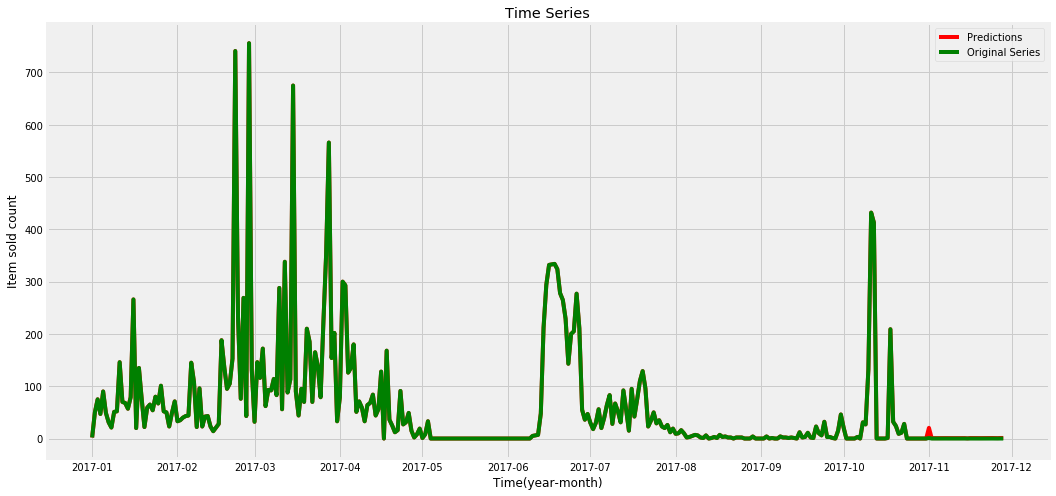

______________
Product: 158737
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'normalize': True, 'fit_intercept': True, 'copy_X': True}

____________________________________________________________________________________________________ 

The RMSE of the Regression Regression is 165.01636925495393
____________________________________________________________________________________________________ 

The MSE of the Regression Regression is 27230.4021220873
____________________________________________________________________________________________________ 

The MAE of the Regression Regression is 127.95896274241484
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 1295.1133400295646
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296
Sum of Predicted Sales for next 28 days:  5878.850956787615
The difference between model original 

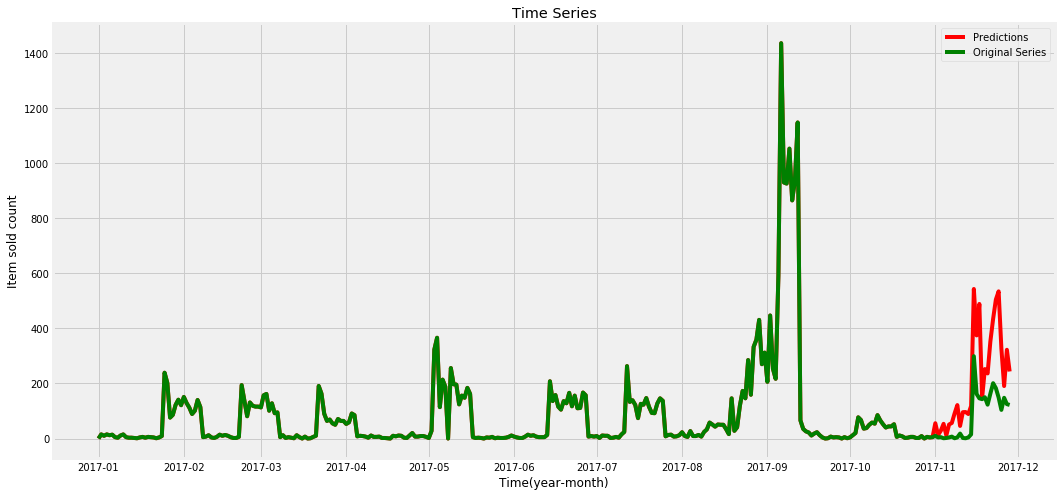

______________
Product: 158105
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'normalize': False, 'fit_intercept': True, 'copy_X': True}

____________________________________________________________________________________________________ 

The RMSE of the Regression Regression is 19.59647084778469
____________________________________________________________________________________________________ 

The MSE of the Regression Regression is 384.0216696880753
____________________________________________________________________________________________________ 

The MAE of the Regression Regression is 14.618054103536425
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 10.503741458316648
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195
Sum of Predicted Sales for next 28 days:  584.7469663944539
The difference between model original 

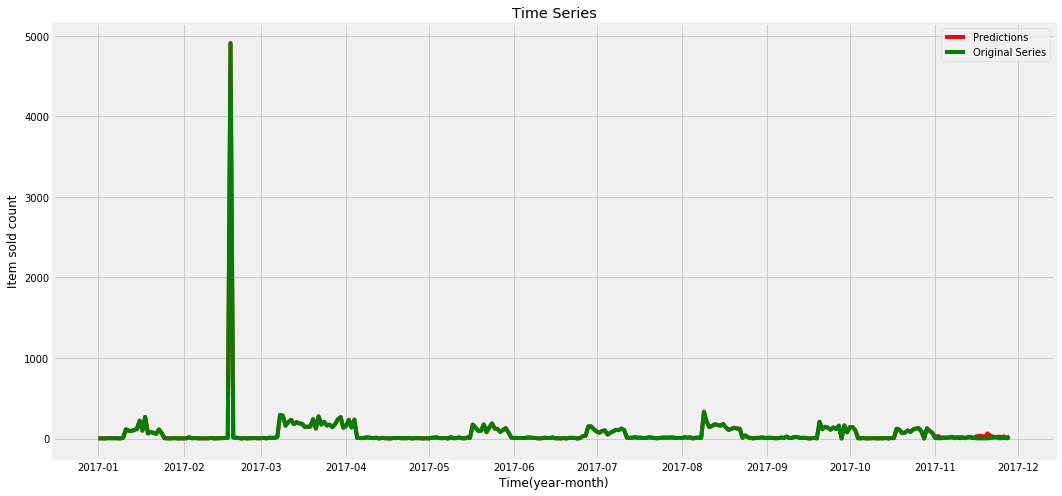

In [19]:
product_list=list(data['product_id'].unique())
    
for i in range(len(list(product_list))):
    print("______________")
    print("Product: "+str(product_list[i]))

    df_train,df_test=pre_process_data(data,product_list[i],28,product_list)
    
    
    # scale features
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    
    params=randomized_search_CV(LinearRegression(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    model = LinearRegression()
    model.set_params(**params)
    model.fit(feature_train_scaled,np.log(df_train['volume_sold']+1))
    
    
    Prediction=model.predict(feature_test_scaled)
    df_test['predictions']=np.exp(Prediction)
    model_quality(df_test,"Regression")
    
    plot_series(df_train,df_test,Prediction)
    

    

#### SVR

In [20]:
tuned_parameters = {'kernel': ['rbf','poly'], 
                    'gamma': [1e-3, 1e-4],
                     'C': [1,10,50,100],
                    'degree':[3,4,6]}
                   

______________
Product: 13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10}

____________________________________________________________________________________________________ 

The RMSE of the  Support Vector Regression Regression is 542.9936084942726
____________________________________________________________________________________________________ 

The MSE of the  Support Vector Regression Regression is 294842.0588656314
____________________________________________________________________________________________________ 

The MAE of the  Support Vector Regression Regression is 410.4633732553642
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 12004.76317498454
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510
Sum of Predicted Sales for next 28 days:  8132.3191576

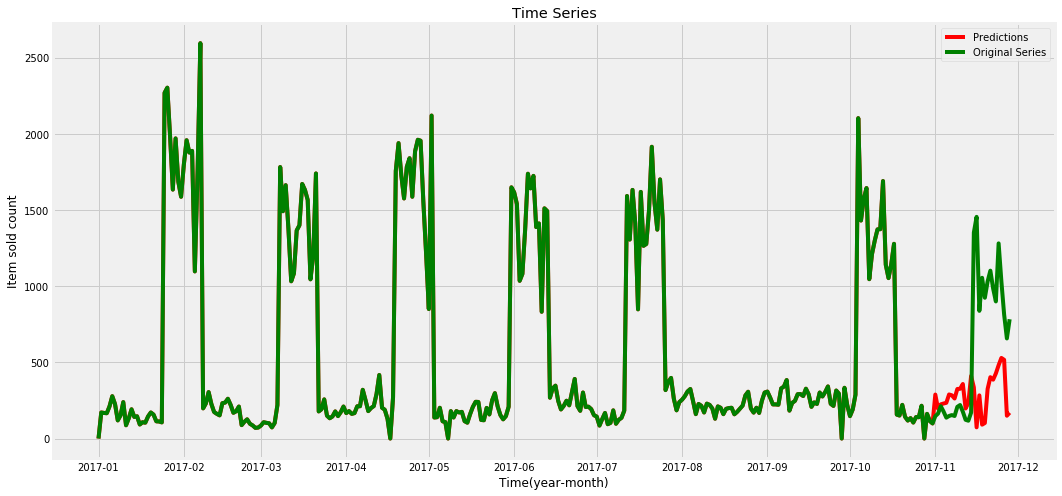

______________
Product: 26104
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.0001, 'degree': 4, 'C': 100}

____________________________________________________________________________________________________ 

The RMSE of the  Support Vector Regression Regression is 4.050554918147603
____________________________________________________________________________________________________ 

The MSE of the  Support Vector Regression Regression is 16.406995144929738
____________________________________________________________________________________________________ 

The MAE of the  Support Vector Regression Regression is 1.5876200646483618
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 0.9503426350961016
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1
Sum of Predicted Sales for next 28 days:  45.45336181

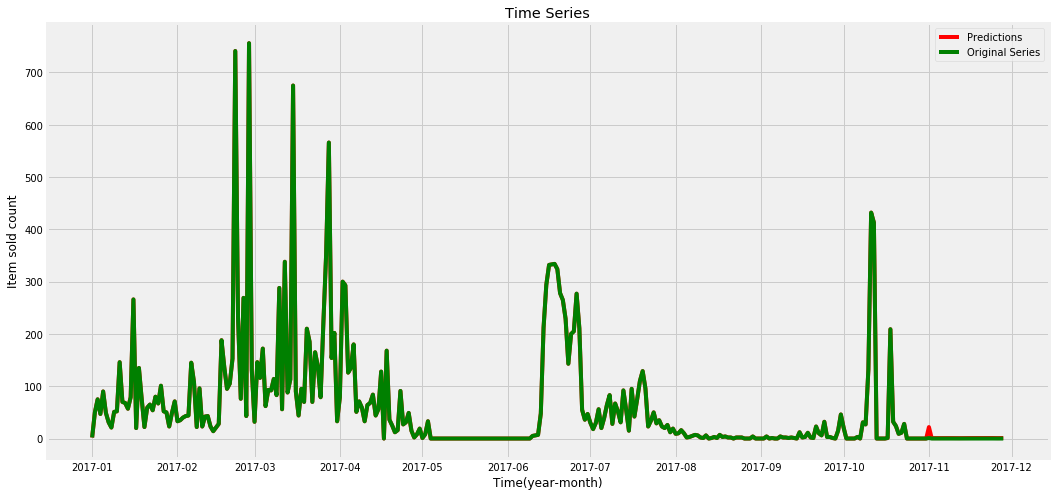

______________
Product: 158737
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.0001, 'degree': 6, 'C': 50}

____________________________________________________________________________________________________ 

The RMSE of the  Support Vector Regression Regression is 52.03043952415271
____________________________________________________________________________________________________ 

The MSE of the  Support Vector Regression Regression is 2707.1666370765124
____________________________________________________________________________________________________ 

The MAE of the  Support Vector Regression Regression is 35.528484728459254
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 130.47492503973024
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296
Sum of Predicted Sales for next 28 days:  2876.2131

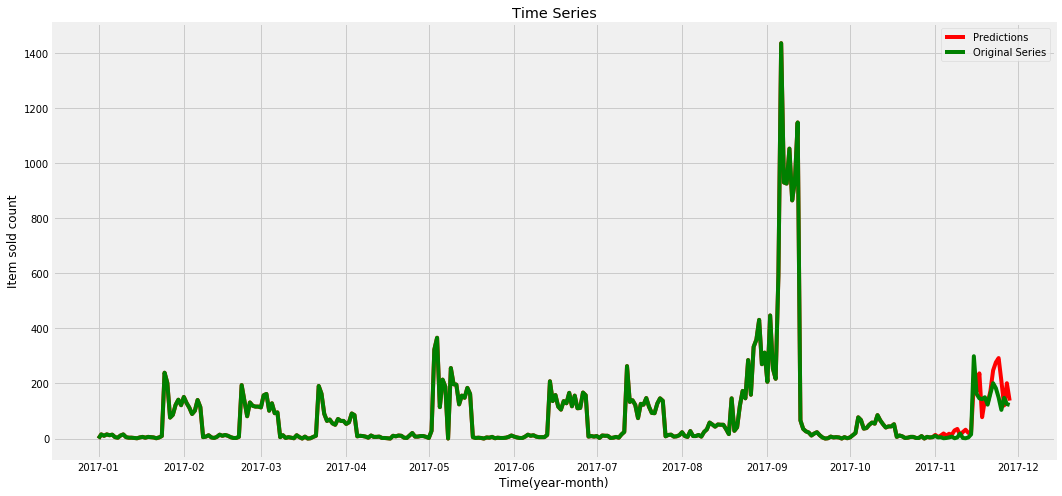

______________
Product: 158105
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 1}

____________________________________________________________________________________________________ 

The RMSE of the  Support Vector Regression Regression is 24.02023203276481
____________________________________________________________________________________________________ 

The MSE of the  Support Vector Regression Regression is 576.9715469078607
____________________________________________________________________________________________________ 

The MAE of the  Support Vector Regression Regression is 19.58605163716638
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 16.14654476827597
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195
Sum of Predicted Sales for next 28 days:  743.40944584065

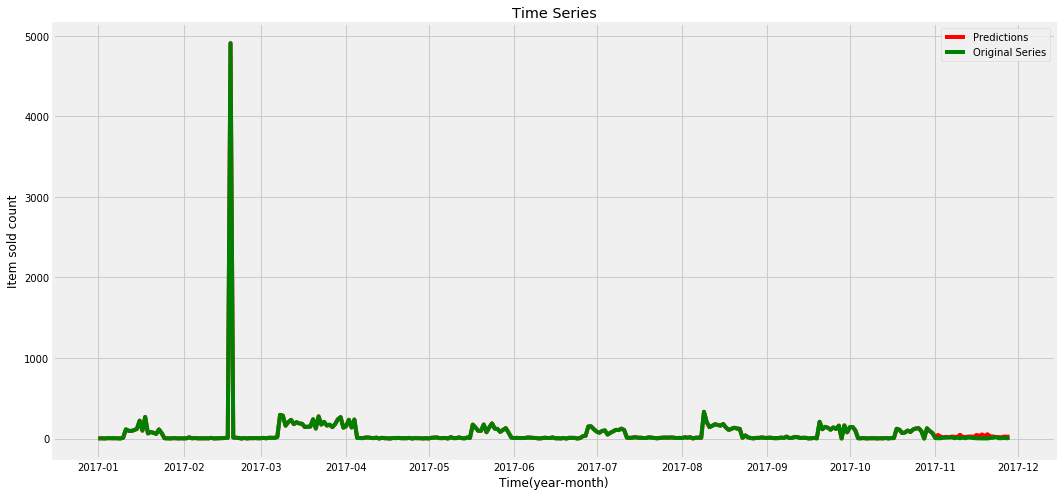

In [21]:
product_list=list(data['product_id'].unique())
for i in range(len(list(product_list))):
    print("______________")
    print("Product: "+str(product_list[i]))

    df_train,df_test=pre_process_data(data,product_list[i],28,product_list)
    
    
    # scale features
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    
    params=randomized_search_CV(SVR(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    model = SVR()
    model.set_params(**params)
    model.fit(feature_train_scaled,np.log(df_train['volume_sold']+1))
    
    
    Prediction=model.predict(feature_test_scaled)
    df_test['predictions']=np.exp(Prediction)
    
    model_quality(df_test," Support Vector Regression")
    
    plot_series(df_train,df_test,Prediction)
    

    

### Random Forest

In [22]:
# A parameter grid for RandomForestRegressor
tuned_parameters = {
        'n_estimators': [100,150,200,300,400],
        'bootstrap': [True, False],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'max_depth': [7,8,9,10]
        }

______________
Product: 13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'bootstrap': False}

____________________________________________________________________________________________________ 

The RMSE of the Random Forest Regression is 339.1469582451815
____________________________________________________________________________________________________ 

The MSE of the Random Forest Regression is 115020.65928695891
____________________________________________________________________________________________________ 

The MAE of the Random Forest Regression is 217.5087066061947
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 4626.223236309225
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510
Sum of Predicted Sales for next 28 days:  2

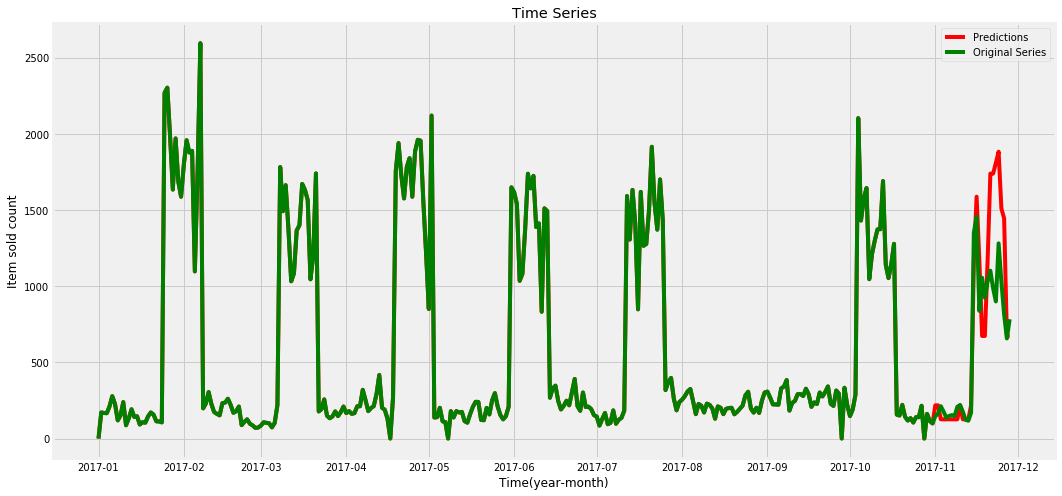

______________
Product: 26104
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}

____________________________________________________________________________________________________ 

The RMSE of the Random Forest Regression is 4.164828384388721
____________________________________________________________________________________________________ 

The MSE of the Random Forest Regression is 17.345795471409964
____________________________________________________________________________________________________ 

The MAE of the Random Forest Regression is 1.7291738890519963
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 1.00025949026327
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1
Sum of Predicted Sales for next 28 days:  49.41

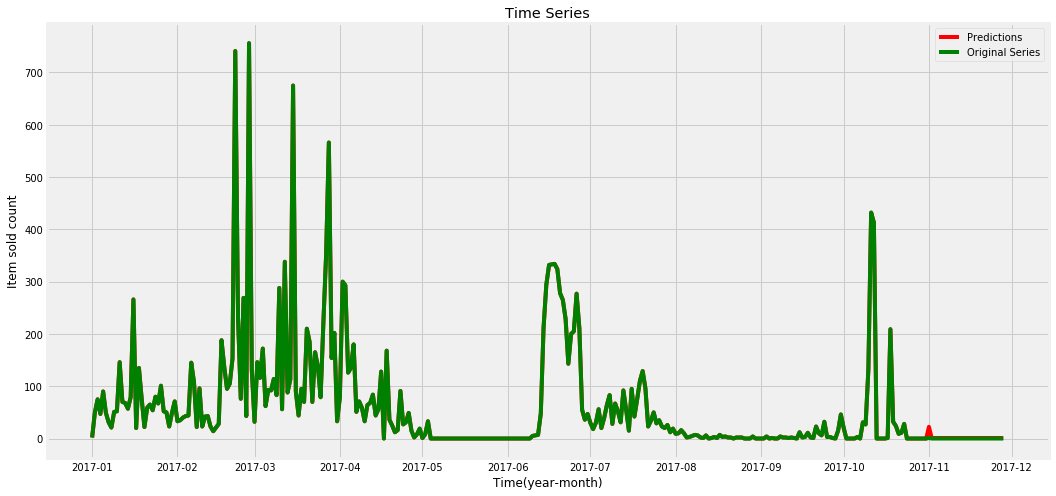

______________
Product: 158737
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}

____________________________________________________________________________________________________ 

The RMSE of the Random Forest Regression is 111.67861011270973
____________________________________________________________________________________________________ 

The MSE of the Random Forest Regression is 12472.111956706633
____________________________________________________________________________________________________ 

The MAE of the Random Forest Regression is 67.08418814732671
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 607.7007151113679
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296
Sum of Predicted Sales for next 28 days:  3

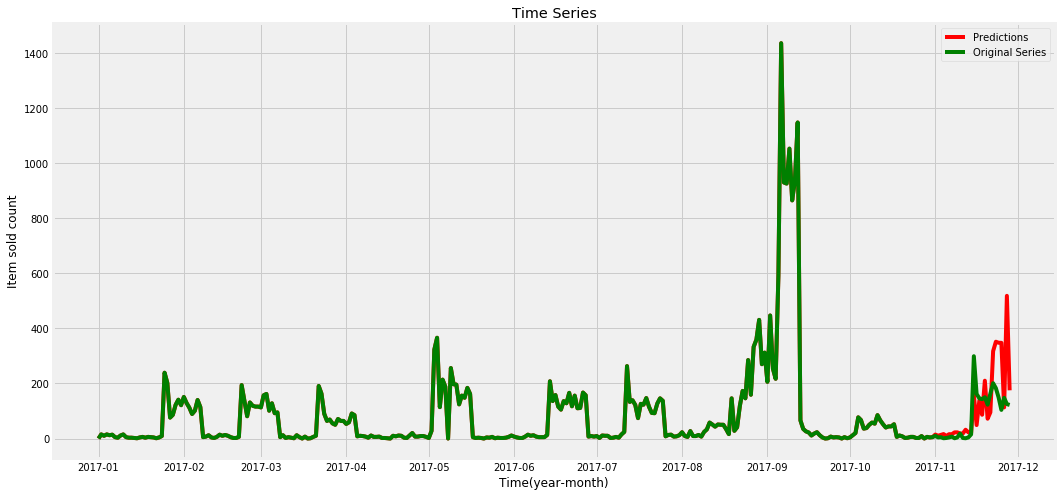

______________
Product: 158105
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 7, 'bootstrap': True}

____________________________________________________________________________________________________ 

The RMSE of the Random Forest Regression is 26.232575360254856
____________________________________________________________________________________________________ 

The MSE of the Random Forest Regression is 688.1480100314501
____________________________________________________________________________________________________ 

The MAE of the Random Forest Regression is 13.391703062476735
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 20.172918416839718
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195
Sum of Predicted Sales for next 28 days:  44

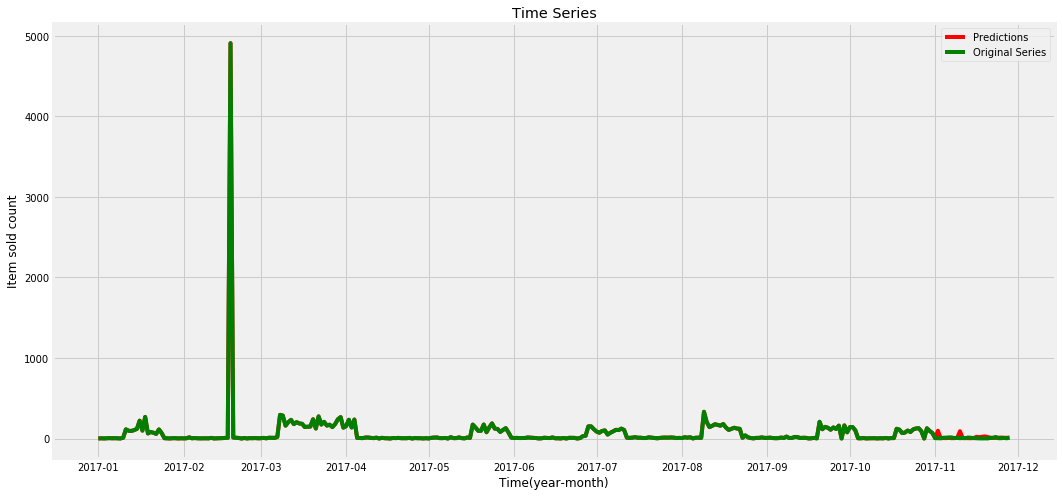

In [23]:
product_list=list(data['product_id'].unique())
for i in range(len(list(product_list))):
    print("______________")
    print("Product: "+str(product_list[i]))

    df_train,df_test=pre_process_data(data,product_list[i],28,product_list)
    
    # scale features
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    
    params=randomized_search_CV(RandomForestRegressor(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    model = RandomForestRegressor()
    model.set_params(**params)
    model.fit(feature_train_scaled,np.log(df_train['volume_sold']+1))
    
    
    Prediction=model.predict(feature_test_scaled)
    df_test['predictions']=np.exp(Prediction)
    
    
    model_quality(df_test,"Random Forest")
    
    plot_series(df_train,df_test,Prediction)
    

    

### XGBoost

In [24]:
# A parameter grid for XGBoost
tuned_parameters = {
        'n_estimators': [10,50,100,150,200,300,400,500],
        'min_child_weight': [3,4],
        'gamma':  [0],
        'subsample': [ 0.7, 0.8],
        'colsample_bytree': [ 0.7, 0.8],
        'max_depth': [7,8],
        'learning_rate' : [ 0.05, 0.1]
        }

______________
Product: 13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.8, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}



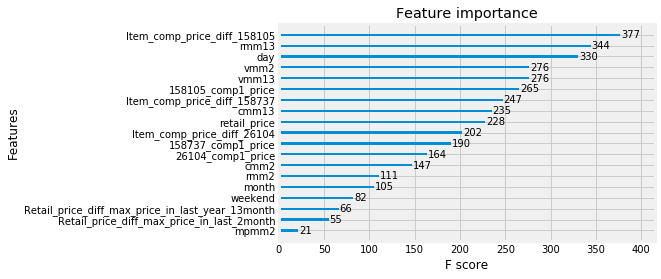

____________________________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 316.06348414187926
____________________________________________________________________________________________________ 

The MSE of the XGBoost Regression is 99896.12600790396
____________________________________________________________________________________________________ 

The MAE of the XGBoost Regression is 204.09084592546736
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 4082.1513112618245
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510
Sum of Predicted Sales for next 28 days:  16394.879
The difference between model original and predictions values of the XGBoost Regression is 115.12109375
_________________________________________________________

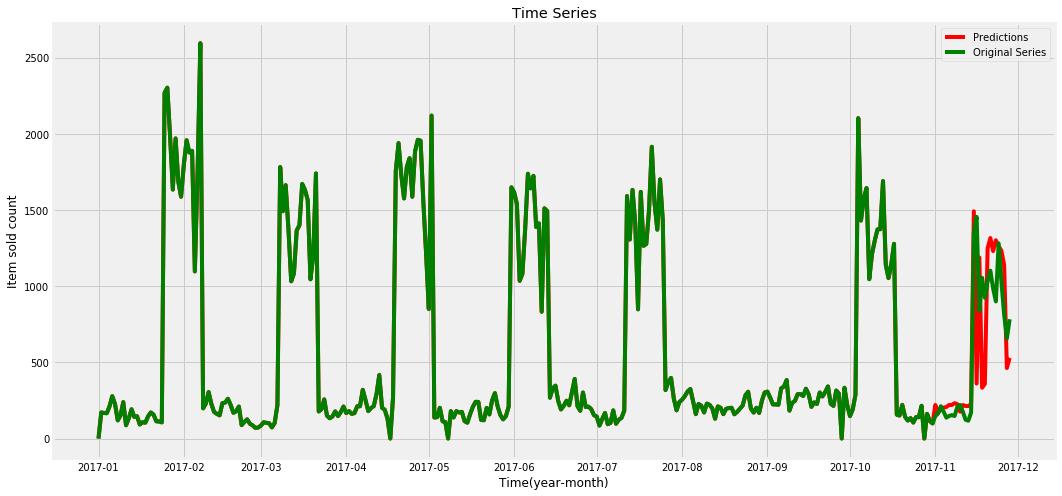

______________
Product: 26104
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}



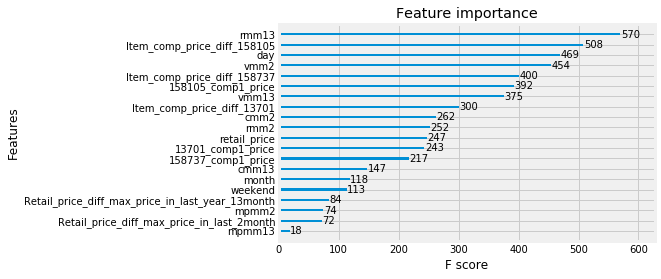

____________________________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 3.410305018557835
____________________________________________________________________________________________________ 

The MSE of the XGBoost Regression is 11.630180319600756
____________________________________________________________________________________________________ 

The MAE of the XGBoost Regression is 1.5869719407388143
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 0.6626297757313213
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1
Sum of Predicted Sales for next 28 days:  45.43521
The difference between model original and predictions values of the XGBoost Regression is -44.435211181640625
_______________________________________________________

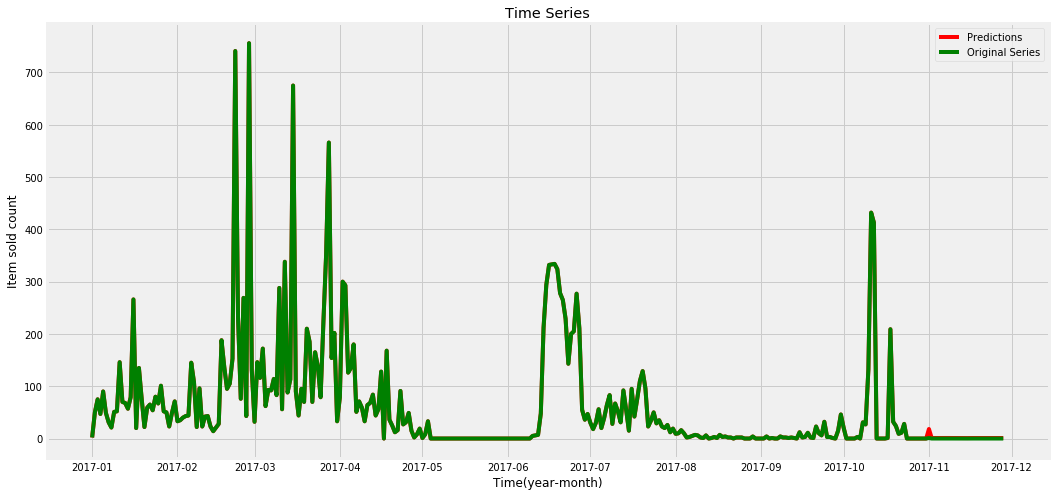

______________
Product: 158737
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}



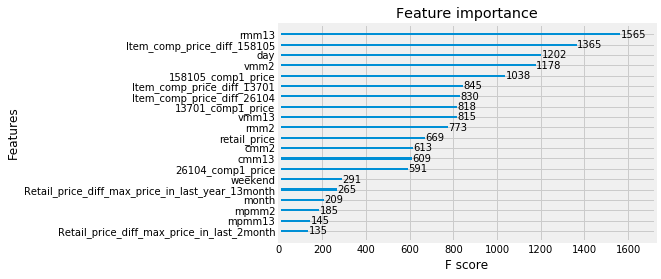

____________________________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 90.14970555984439
____________________________________________________________________________________________________ 

The MSE of the XGBoost Regression is 8126.969412526638
____________________________________________________________________________________________________ 

The MAE of the XGBoost Regression is 64.18110305922372
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 402.7400582138256
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296
Sum of Predicted Sales for next 28 days:  2263.5798
The difference between model original and predictions values of the XGBoost Regression is 32.420166015625
__________________________________________________________

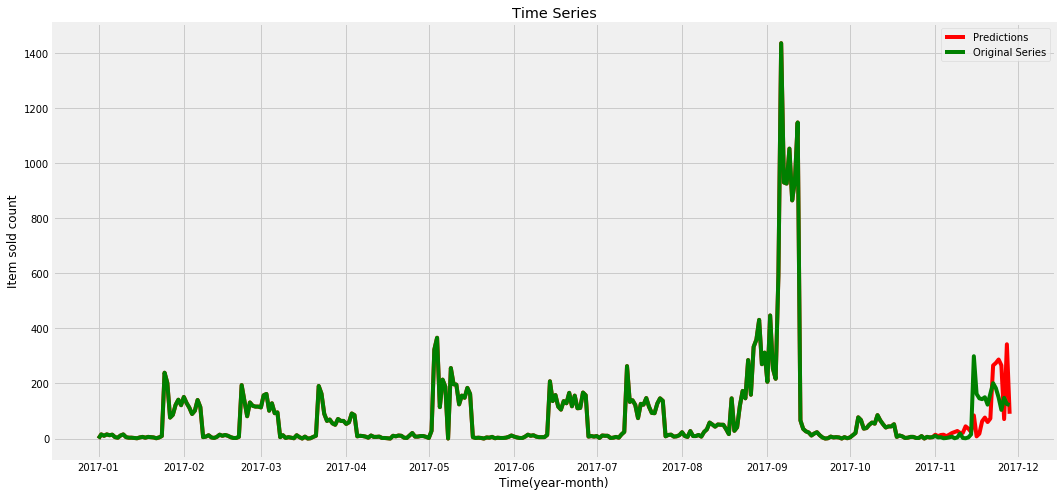

______________
Product: 158105
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.7, 'n_estimators': 50, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}



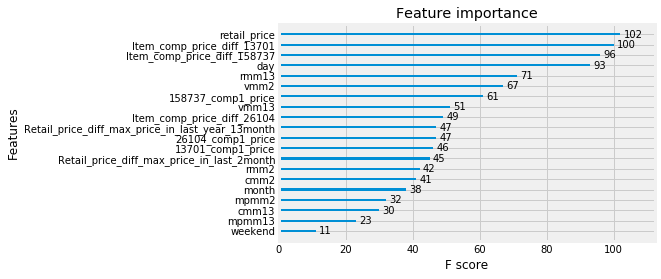

____________________________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 15.235932906635796
____________________________________________________________________________________________________ 

The MSE of the XGBoost Regression is 232.13365153550748
____________________________________________________________________________________________________ 

The MAE of the XGBoost Regression is 10.149176725319453
____________________________________________________________________________________________________ 

Normalized weighted mean sqaure error: 7.0081069823033255
____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195
Sum of Predicted Sales for next 28 days:  305.36102
The difference between model original and predictions values of the XGBoost Regression is -110.36102294921875
___________________________________________________

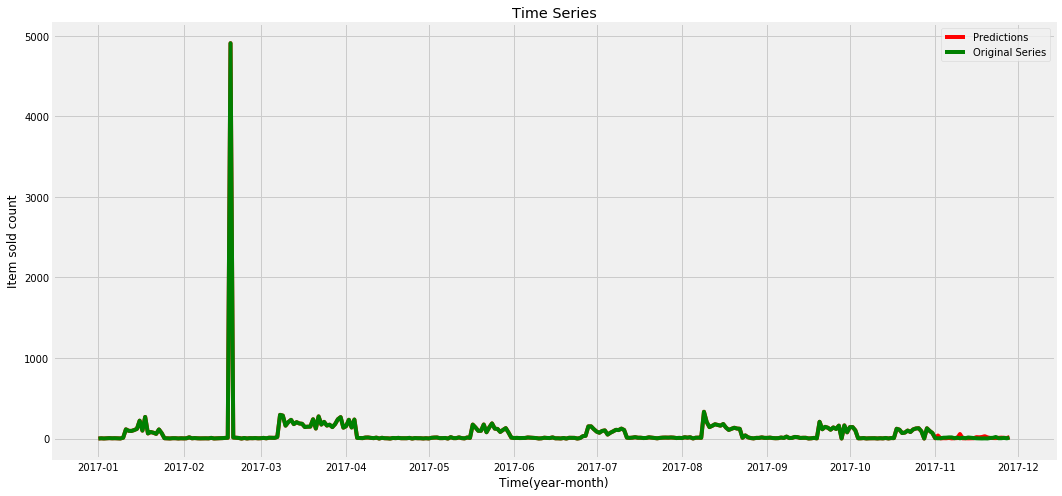

In [25]:
product_list=list(data['product_id'].unique())
for i in range(len(list(product_list))):
    print("______________")
    print("Product: "+str(product_list[i]))

    df_train,df_test=pre_process_data(data,product_list[i],28,product_list)
    
    # scale features
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    
    params=randomized_search_CV(XGBRegressor(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    model = XGBRegressor()
    model.set_params(**params)
    model.fit(feature_train_scaled,np.log(df_train['volume_sold']+1))
    
    
    Prediction=model.predict(feature_test_scaled)
    df_test['predictions']=np.exp(Prediction)
    
    
    plot_importance(model)
    pyplot.show()
    
    model_quality(df_test,"XGBoost")
    
    plot_series(df_train,df_test,Prediction)
    

    